In [1]:
%load_ext autoreload
%autoreload 2
from skimage import io
import numpy as np
from scipy.spatial import Delaunay
import networkx as nx
import matplotlib.pyplot as plt
import voronoi
import misc
from misc import show_img
import prop

In [2]:
def calculate_all_shape_props(imgs_mask_paths, shape_props_to_measure):
    '''Calculate shape properties for glands in mask images given by `imgs_mask_paths`'''
    
    all_shape_props = []
    for img_mask_path in imgs_mask_paths:
        img_mask = io.imread(img_mask_path)
        img_mask = misc.mask_correction(img_mask)

        # Shape properties
        shape_props = prop.get_shape_props_from_mask(img_mask, shape_props_to_measure)
        all_shape_props.append(shape_props)
        
    # Combine all shape properties into a single list
    all_shape_props_concat, _ = combine_class_values(all_shape_props)
        
    # Calculate mean and standard deviation
    shape_props_mean = np.mean(all_shape_props_concat, axis=0)
    shape_props_std = np.std(all_shape_props_concat, axis=0)
        
    return all_shape_props, shape_props_mean, shape_props_std

def calculate_all_net_props(imgs_mask_paths, all_shape_props_norm, alpha=0, att_idx=None):
    '''Calculate graph properties for glands in mask images given by `imgs_mask_paths`'''
    
    # First, generate all networks
    all_nets = []
    indices = [0]
    for img_idx, img_mask_path in enumerate(imgs_mask_paths):
        img_mask = io.imread(img_mask_path)
        img_mask = misc.mask_correction(img_mask)

        # Calculate Voronoi
        g, points, cell_collection = voronoi.voronoi_from_mask(img_mask)
        
        all_nets.append(g)
        indices.append(indices[-1]+g.vcount())
        
    # Concatenate the positions of all glands in all images
    all_pos_concat = []
    for g in all_nets:
        all_pos_concat.extend(g.vs["pos"])
        
    all_pos_concat_norm = prop.normalize_values(all_pos_concat)
    
    # Separate the values for each image
    all_pos_norm = separate_class_values(all_pos_concat_norm, indices)
        
    # Network properties
    all_net_props = []
    for img_idx, img_mask_path in enumerate(imgs_mask_paths):
        
        pos_nodes = all_pos_norm[img_idx]
        shape_props = all_shape_props_norm[img_idx]
        g = all_nets[img_idx]
        
        nxgraph = misc.igraph_to_nx(g)
        
        if(len(shape_props[ : , 0 ]) != g.vcount()):
            print('ALERT! PROPERTIES TABLE MUST HAVE THE SAME NUMBER OF GRAPH VERTICES')
        else:
            print(str(g.vcount()) + ' Glands')

        # Edge weights    
        weight_dict = prop.calculate_weight_all(nxgraph, pos_nodes, shape_props, att_idx=att_idx, normalize_pos=False, 
                                                normalize_att=False)
        weights = list(weight_dict.values())
        nx.set_edge_attributes(nxgraph, weight_dict, 'weight')

        #Network Properties
        net_props = prop.get_graph_props(nxgraph)
        all_net_props.append(net_props)
        
    # Combine all values
    all_net_props_concat, _ = combine_class_values(all_net_props)
        
    net_props_mean = np.mean(all_net_props_concat, axis=0)
    net_props_std = np.std(all_net_props_concat, axis=0)
        
    return all_net_props, net_props_mean, net_props_std
    
def combine_class_values(values_list):
    '''Combine properties measured for different images into a single list. `values_list` is a list
    where each element is another list containing features measured for an image.
    `indices` will contain the indices that can be used to separate the data into different classes
    again.
    '''
    
    values_list_concat = []
    indices = [0]
    for values in values_list:
        values_list_concat += list(values)
        indices.append(indices[-1]+len(values))
    return values_list_concat, indices

def separate_class_values(values, indices):
    '''Separate values into different classes.'''
    
    values_sep = []
    for idx in range(len(indices)-1):
        first_index = indices[idx]
        last_index = indices[idx+1]
        values_sep.append(values[first_index:last_index])
    return values_sep

def combine_features(values1, values2):
    '''Combine two sets of features intoa single table (ex: shape properties and net properties).'''
    
    if len(values1)!=len(values2):
        raise ValueError('Cannot combine features, number of rows must be equal')
    
    combined_values = []
    for idx in range(len(values1)):
        combined_values.append(values1 + values2)
        
    return combined_values

In [3]:
# Parameters
shape_props_to_measure = ['area', 'solidity', 'eccentricity', 'equivalent_diameter', 'perimeter']

# Define data paths
root_img_path = 'img'
result_path = 'results'
img_mask_names = ['S07_46186_lower_10X_Snapshot_20151028_59-- NORMAL - MASK.jpg', 
                  'S07_46186_lower_10X_Snapshot_20151028_59-- CA 3 - MASK.jpg']

imgs_mask_paths = [root_img_path+'/'+fn for fn in img_mask_names]

In [4]:
shape_props, shape_props_mean, shape_props_std = calculate_all_shape_props(imgs_mask_paths, shape_props_to_measure)
# Normalize shape properties using calculated mean and standard deviation
shape_props_norm = []
for sp in shape_props:
    shape_props_norm.append(prop.normalize_values(sp, shape_props_mean, shape_props_std))

net_props, net_props_mean, net_props_std = calculate_all_net_props(imgs_mask_paths, shape_props_norm)
# Normalize net properties using calculated mean and standard deviation
net_props_norm = []
for np in net_props:
    net_props_norm.append(prop.normalize_values(np, net_props_mean, net_props_std))

52 Glands
186 Glands


# Combine Shapes and Network Properties

In [20]:
allProps = []
for row in range(g.vcount()):
    rowProp = []
    
    #Adding shape properties
    for colShape in range(len(shape_props[0])):
        rowProp.append(shape_props[row][colShape])
        
    #Adding network properties
    for colNet in range(len(net_props[0])):
        rowProp.append(net_props[row][colNet])
    
    allProps.append(rowProp)   
    
allProps = np.array(allProps)

#Normalize values
allPropsNormalized = np.zeros( (len(allProps[:,0]), len(allProps[0])) )
for col in range(len(allProps[0])):
    allPropsNormalized[:,col] = prop.normalize_values(allProps[:,col])

In [22]:
if isHealth:
    healthProps = allProps
    healthPropsShape = shape_props
    healthPropsNet = net_props
else:
    unHealthProps = allProps
    unHealthPropsShape = shape_props
    unHealthPropsNet = net_props

In [23]:
numUnhealth = len(unHealthPropsShape)
numHealth = len(healthPropsShape)
print("Unhealth properties: " + str(numUnhealth))
print("Health properties: " + str(numHealth))

NameError: name 'unHealthPropsShape' is not defined

# Combine Unhealth and Health Properties

In [24]:
allPropsCombined = []
for idx, prop in enumerate(unHealthProps):
    allPropsCombined.append(prop)
for idx, prop in enumerate(healthProps):
    allPropsCombined.append(prop)    
    
allPropsShapeCombined = []
for idx, prop in enumerate(unHealthPropsShape):
    allPropsShapeCombined.append(prop)
for idx, prop in enumerate(healthPropsShape):
    allPropsShapeCombined.append(prop)

allPropsNetCombined = []
for idx, prop in enumerate(unHealthPropsNet):
    allPropsNetCombined.append(prop)    
for idx, prop in enumerate(healthPropsNet):
    allPropsNetCombined.append(prop)
    
print("All properties: " + str(len(allPropsCombined)))
print("All properties of shapes: " + str(len(allPropsShapeCombined)))
print("All properties of network: " + str(len(allPropsNetCombined)))

NameError: name 'unHealthProps' is not defined

# PCA Scatter Plot Blue Points are Health and Red Point are Unhealth

In [827]:
def plot_hist_two_arrays(arr1, arr2, num_bins, alpha=0.5):

    min_val = np.min((arr1.min(), arr2.min()))
    max_val = np.max((arr1.max(), arr2.max()))
    print(min_val)
    print(max_val)
    bins = np.linspace(min_val, max_val, num_bins)

    plt.figure()
    plt.hist(arr1, bins, density=True, alpha=alpha, color='red')
    plt.hist(arr2, bins, density=True, alpha=alpha, color='blue')

In [828]:
def plot_pca_two_arrays(arr1, arr2, nro1, nro2, alpha=0.5):
    colors = ['red']*nro1 + ['blue']*nro2

    plt.figure()
    fig = plt.figure(figsize=(20,15))
    plt.subplot(3, 4, 1)
    plt.scatter(arr1, arr2, color=colors, alpha=alpha, lw=2)
    plt.title('GLCM')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

In [829]:
propsAll = np.array(allPropsCombined)
PCAdataAll, eigenvaluesAll, main_eigenvectorsAll = misc.PCA(propsAll, 2, False)

propsShape = np.array(allPropsShapeCombined)
PCAdataShape, eigenvaluesShape, main_eigenvectorsShape = misc.PCA(propsShape, 2, False)

propsNet = np.array(allPropsNetCombined)
PCAdataNet, eigenvaluesNet, main_eigenvectorsNet = misc.PCA(propsNet, 2, False)

# Only one property

In [830]:
column = propsAll[:,0]
columnNorm = zscore(column)

columnUnhealth = column[0:186]
columnHealth = column[186:len(column)]

columnUnhealthNorm = columnNorm[0:186]
columnHealthNorm = columnNorm[186:len(columnNorm)]

62.0
38631.0


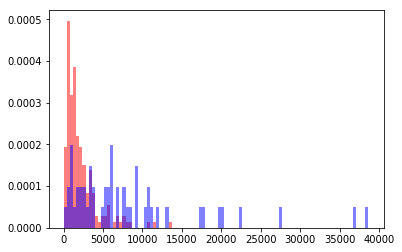

In [831]:
plot_hist_two_arrays(columnUnhealth, columnHealth, 100, alpha=0.5)

-0.6869049632033163
6.957577142951671


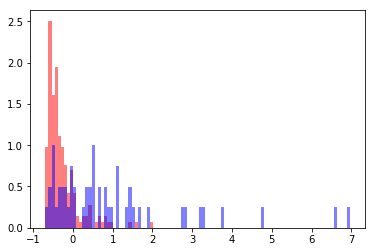

In [832]:
plot_hist_two_arrays(columnUnhealthNorm, columnHealthNorm, 100, alpha=0.5)

In [833]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

cols = ['COLUMN']
data = pd.DataFrame(column, columns = cols)

scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(data[cols])

scaledUnhealth = scaled_data[0:186]
scaledHealth = scaled_data[186:len(scaled_data)]

0.0
0.9999999999999999


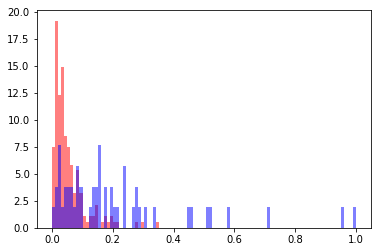

In [834]:
plot_hist_two_arrays(scaledUnhealth, scaledHealth, 100, alpha=0.5)

### - PCA Only Shapes Properties

-10.01601672386196
2.9569802114572186


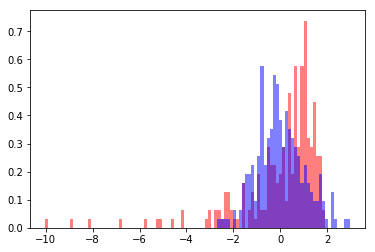

In [835]:
plot_hist_two_arrays(PCAdataShape[:,0], PCAdataShape[:,1], num_bins=100)

### - PCA Only Net Properties

-3.3361422849482922
3.9195883582549333


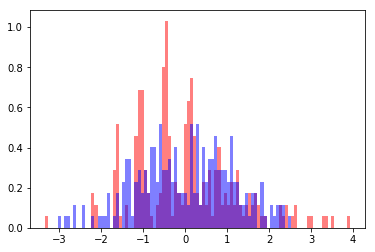

In [836]:
plot_hist_two_arrays(PCAdataNet[:,0], PCAdataNet[:,1], num_bins=100)

### - PCA Shapes and Network

-10.898246718251318
4.028532932329881


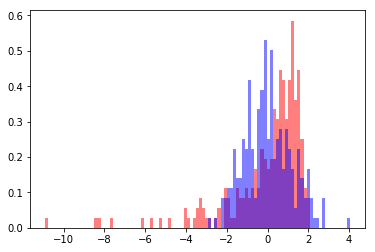

In [837]:
plot_hist_two_arrays(PCAdataAll[:,0], PCAdataAll[:,1], num_bins=100)

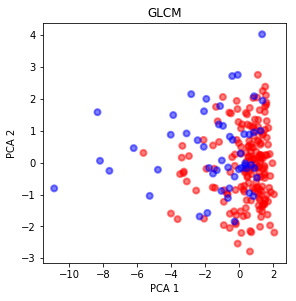

In [838]:
plot_pca_two_arrays(PCAdataAll[:,0], PCAdataAll[:,1], numUnhealth, numHealth, alpha=0.5)

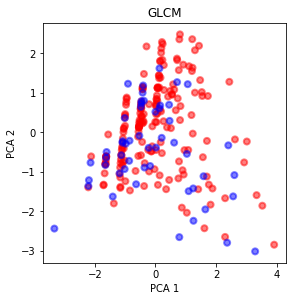

In [839]:
plot_pca_two_arrays(PCAdataNet[:,0], PCAdataNet[:,1], numUnhealth, numHealth, alpha=0.5)

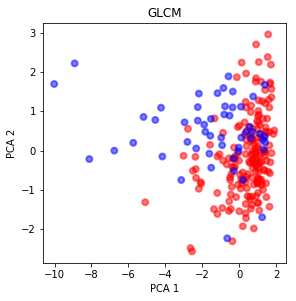

In [840]:
plot_pca_two_arrays(PCAdataShape[:,0], PCAdataShape[:,1], numUnhealth, numHealth, alpha=0.5)

# Classify K-Neighbors with 80% training and 20% validation

In [841]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors, datasets, metrics

### Randon Total Number of Health to Unhealth (52-52)

In [843]:
k = 3            # Number of neighbors for the k-nearest neighbors classifier
n_train = 42     # Number of objects for training
n_validate = 10  # Number of objects for validation
n_classes = 2    # Number of classes in the dataset

### Random Choice to the major class

In [844]:
arraySize = numHealth
rangeSize = numUnhealth
random_index = np.random.choice(rangeSize, arraySize, replace=False)

### Area and Diameter properties

In [857]:
allPropsShapeCombinedNormalized = zscore(allPropsShapeCombined)

unHealthPropsShapeNormalized = allPropsShapeCombinedNormalized[0:numUnhealth]
healthPropsShapeNormalized = allPropsShapeCombinedNormalized[numUnhealth:]

unhealth_random_area = unHealthPropsShapeNormalized[:,0][random_index]
unhealth_random_diameter = unHealthPropsShapeNormalized[:,3][random_index]

health_random_area = healthPropsShapeNormalized[:,0]
health_random_diameter = healthPropsShapeNormalized[:,3]

area_diameter = []
unhealth_area_diameter = []
for i in range(arraySize):
    row = []
    row.append(unhealth_random_area[i])
    row.append(unhealth_random_diameter[i])
    
    unhealth_area_diameter.append(row)
    area_diameter.append(row)
    
health_area_diameter = []
for i in range(arraySize):
    row = []
    row.append(health_random_area[i])
    row.append(health_random_diameter[i])
    
    health_area_diameter.append(row)
    area_diameter.append(row)
    
area_diameter = np.array(area_diameter)
area_diameter_target = np.array([0]*numHealth + [1]*numHealth)    

### Normalize Area and Diameter

In [858]:
#area_diameter_normalized = np.zeros(area_diameter.shape)
#for col in range(len(area_diameter[0])):
#    area_diameter_normalized[:,col] = zscore(area_diameter[:,col])

In [904]:
properties = area_diameter_normalized

# Split the dataset into training and validation
res = misc.split_dataset(properties, classes=area_diameter_target, n_train=n_train)
properties_train, properties_validate, classes_train, classes_validate = res

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(k)
clf.fit(properties_train, classes_train)

# Predict the class using the validation set
classes_pred = clf.predict(properties_validate)

# Get accuracy
acc = metrics.accuracy_score(classes_validate, classes_pred)
print("Area and Diameter Acurrary")
print(acc)

Area and Diameter Acurrary
0.7


### Only Shape Properties

In [906]:
unhealth_random_all = unHealthPropsShapeNormalized[random_index]

all_properties = []
unhealth_all = []
for r in range(arraySize):
    row = []
    for c in range(len(unhealth_random_all[0])):
        row.append(unhealth_random_all[r][c])
    
    unhealth_all.append(row)
    all_properties.append(row)
    
health_all = []
for r in range(arraySize):
    row = []
    for c in range(len(healthPropsShapeNormalized[0])):
        row.append(healthPropsShapeNormalized[r][c])
    
    health_all.append(row)
    all_properties.append(row)

all_properties = np.array(all_properties)
all_properties_target = np.array([0]*numHealth + [1]*numHealth)    

### Normalize all properties

In [907]:
#all_properties_normalized = np.zeros(all_properties.shape)
#for col in range(len(all_properties[0])):
#    all_properties_normalized[:,col] = zscore(all_properties[:,col])

In [934]:
properties = all_properties_normalized

# Split the dataset into training and validation
res = misc.split_dataset(properties, classes=area_diameter_target, n_train=n_train)
properties_train, properties_validate, classes_train, classes_validate = res

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(k)
clf.fit(properties_train, classes_train)

# Predict the class using the validation set
classes_pred = clf.predict(properties_validate)

# Get accuracy
acc = metrics.accuracy_score(classes_validate, classes_pred)
print("Shape Acurrary")
print(acc)

Shape Acurrary
0.7


### Shapes and Network 

In [935]:


unhealth_random_all = unHealthProps[random_index]

all_properties = []
for r in range(arraySize):
    row = []
    for c in range(len(unhealth_random_all[0])):
        row.append(unhealth_random_all[r][c])
    
    all_properties.append(row)
    
health_all = []
for r in range(arraySize):
    row = []
    for c in range(len(healthProps[0])):
        row.append(healthPropsNormalized[r][c])
    
    all_properties.append(row)

all_properties = np.array(all_properties)
all_properties_target = np.array([0]*numHealth + [1]*numHealth)    

NameError: name 'unHealthPropsNormalized' is not defined

### Normalize all properties

In [630]:
all_properties_normalized = np.zeros(all_properties.shape)
for col in range(len(all_properties[0])):
    all_properties_normalized[:,col] = zscore(all_properties[:,col])

In [693]:
properties = all_properties_normalized

# Split the dataset into training and validation
res = misc.split_dataset(properties, classes=area_diameter_target, n_train=n_train)
properties_train, properties_validate, classes_train, classes_validate = res

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(k)
clf.fit(properties_train, classes_train)

# Predict the class using the validation set
classes_pred = clf.predict(properties_validate)

# Get accuracy
acc = metrics.accuracy_score(classes_validate, classes_pred)
print("Shape and Net Acurrary")
print(acc)

Shape and Net Acurrary
0.95


### PCA

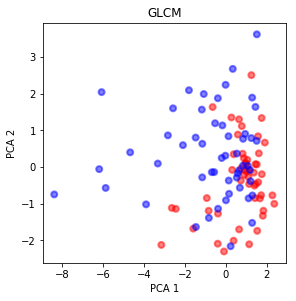

In [635]:
PCAdataAllProperties, ev, main_ev = misc.PCA(properties, 2, False)
plot_pca_two_arrays(PCAdataAllProperties[:,0], PCAdataAllProperties[:,1], numHealth, numHealth, alpha=0.5)